In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

![Cover](../../../docs/images/assessing_risks_geospatial_bqml/cover.jpg)
# Assessing Geological Risks to Protect Agricultural Investments

| Author |
| --- |
| [Luis Gerardo Baeza](https://github.com/lgbaeza) |

## Scenario
For agribusinesses and their financial investors and insurers, accurately quantifying the financial risk from a production shortage is a big analytical challenge and an important one to solve. The direct impact of a fire or a drought is on the crop yield potential loss. These events lead to revenue loss, disrupt supply chain operations, and have financial consequences.

## Goal
On this notebook, we use the vast repository of public satellite imagery and environmental data available through Google Earth Engine, which is available as rasterized data directly within BigQuery. As an example, we will walk you through analyzing the wine production in Chile, to create dynamic wildfire risk intelligence system. By joining this environmental data with the geographic locations of vineyards and other assets, stakeholders can generate precise risk assessments for specific areas of interest.

## High-level flow
* **Access Chilean Regions of Interest:** Use Overture Maps in BigQuery Sharing to access regional data. Combine this data with official wine production statistics to map regions of interest and their geographical boundaries using the GEOGRAPHY data type in BigQuery.
* **Explore Environmental Data:** Quickly explore environmental characteristics using Earth Engine’s public datasets. Analyze elevation, wildfires history, water irrigation, and availability, as well as net primary prodictiviy using datasets such as the NASA Digital Elevation Model, GFSAD Cropland, and GLOBathy Global Lakes Bathymetry.
* **Perform Raster Analysis with ST_RegionStats():** Apply the ST_RegionStats() function to compute aggregate statistics (e.g., mean, sum, standard deviation) for raster data within Chilean regions defined by BigQuery geographies. This allows for summarizing raster insights over vector boundaries.
* **Visualize and Interpret Results:** Export or connect BigQuery results to geospatial visualization tools (e.g., GeoViz, Data Studio, Looker, Carto) to interpret and communicate findings effectively.
* **Get actionable insights:** Develop a Machine Learning model to predict risk areas and take timely actions.

## Going further
This is just a case study that might get your attention if you are a wine enthusiast, however, the same technology stack can solve complex location-based problems in a wide variety of companies and industries, from logistics network optimization to mineral exploration.

## Step 0: Setup

In [24]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
import bigframes.pandas as bpd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import wkt
import os

Configure a project id and location.

In [25]:
GOOGLE_CLOUD_PROJECT = os.environ.get( 'GOOGLE_CLOUD_PROJECT' )
PROJECT_ID = GOOGLE_CLOUD_PROJECT # @param {type:"string"}
BIGQUERY_DATASET = 'demo_datascience_book' # @param {type:"string"}
GCP_LOCATION = "us-central1" # @param {type:"string"}

In [26]:
bq_client = bigquery.Client( )
storage_client = storage.Client( )

Create a [Cloud Storage bucket.](https://cloud.google.com/storage/docs/creating-buckets?utm_campaign=CDR_0x225cfd13_default_b407565440&utm_source=external&utm_medium=web)

In [ ]:
BUCKET_NAME = f"{ GOOGLE_CLOUD_PROJECT }-demo-wine"

try:
  bucket_obj = storage_client.create_bucket( BUCKET_NAME, location = GCP_LOCATION )
  print( bucket_obj )
except Exception as ex:
  print( ex )

In [211]:
def quick_plot_map( df, geo_col, columns_color, size_x = 8, size_y = 8, subplots_x = 1, subplots_y = 1, title = None ):
  gdf = gpd.GeoDataFrame( df, geometry = geo_col)
  fig, ax = plt.subplots( subplots_y, subplots_x, figsize = ( size_y, size_x ) )

  if subplots_x * subplots_y == 1:
      ax_flat = [ ax ]
  else:
    ax_flat = ax.flatten( )

  for i, col_color in enumerate( columns_color ):
    current_ax = ax_flat[ i ]
    gdf.plot(
        column = col_color,
        ax = current_ax,
        legend = True,
        cmap = 'inferno',
        legend_kwds = { 'label' : col_color, 'orientation': "horizontal" }
    )

    # title and labels
    if title is None:
      current_ax.set_title( col_color.upper( ), fontdict = { 'fontsize': '12', 'fontweight': '3' } )
    else:
      current_ax.set_title( title, fontdict = { 'fontsize': '12', 'fontweight': '3' } )

    current_ax.set_xlabel( 'Longitude' )
    current_ax.set_ylabel( 'Latitude' )

  plt.show( )

## Step 1: Load data
For the demonstration, we will use both publicly available data and a private-sourced table with the wine production in Chile by Region:
- a) **Geographical regions in Chile** from the overture_maps dataset available in bigquery-public-data.
- b) **Raster data** in Earth Engine (satellite images) from where we will extract  earth characteristics in regions of interest in Chile, like elevation, water irrigation and inland water body depth.
- c) **Net primary production** (NPP) available in modis_terra_net_primary_production dataset of bigquery-public-data: a global measure of vegetation productivity.
- d) **Wine production in Chile by region** within in a custom provided CSV file.
- e) **Fire risk for Chilean regions** available in the nasa_wildfire.past_week table of bigquery-public-data.

Creation of a BigQuery dataset for the sample

In [29]:
SQL = f"""
  CREATE SCHEMA IF NOT EXISTS { BIGQUERY_DATASET };
"""

In [ ]:
%%bigquery
$SQL

**a) Regions in Chile**

The [overture maps dataset](https://docs.overturemaps.org/) in BigQuery public data provides free and open map data with representations of human settlements, such as countries, regions, states, cities, and even neighborhoods. The *geometry* column is a BigQuery Geography data type containing polygons with the boundaries for political divisions that we need, in this case, Chilean regions.

In [77]:
SQL = f"""
CREATE OR REPLACE TABLE `{ GOOGLE_CLOUD_PROJECT }.{ BIGQUERY_DATASET }.cl_regions` AS
SELECT
    names.primary AS region_name
  , region
  , st_Union_agg( geometry ) AS geometry
FROM
  `bigquery-public-data.overture_maps.division_area`
WHERE
  country = 'CL' AND subtype = 'region'
  GROUP BY 1,2
  ORDER BY region
"""

In [ ]:
%%bigquery
$SQL

**b) Earth features from raster data in Earth Engine**

Using Earth Engine's public datasets, we can acquire elevation, wildfires, water irrigation, and availability insights.
* The [**Digital Elevation Model**](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003#description) provides valuable elevation data, which is relevant for wine grape growing..
* The [**Cropland dataset**](https://developers.google.com/earth-engine/datasets/catalog/USGS_GFSAD1000_V1) provides the *landcover* band with information about water irrigation used for crops. A number between 1 - 2 means that either major or minor irrigation is performed. While a 0 value means there are no croplands. Water irrigation might influence water availability for wine acvitiy.
* The [**Bathymetry**](https://developers.google.com/earth-engine/datasets/catalog/projects_sat-io_open-datasets_GLOBathy_GLOBathy_bathymetry) dataset contains detailed bathymetric maps by integrating maximum depth estimates comprising data on over 1.4 million waterbodies globally.

In [116]:
SQL = f"""
  CREATE OR REPLACE TABLE `{ GOOGLE_CLOUD_PROJECT }.{ BIGQUERY_DATASET }.earth_features_cl` AS
  SELECT
    region
    , region_name
    , ST_RegionStats(
          geometry
        , 'ee://USGS/SRTMGL1_003'                                   -- Digital elevation model (DEM)
        , 'elevation'
      ) AS elevation
    , ST_RegionStats(
          geometry
        , 'USGS/GFSAD1000_V1'                                      -- Cropland
        , 'landcover'
    ) AS landcover
    , ST_RegionStats(
          geometry
        , 'projects/sat-io/open-datasets/GLOBathy/GLOBathy_bathymetry'     -- Bathymetry
        , 'b1'
    ) AS water
  FROM
    `{ GOOGLE_CLOUD_PROJECT }.{ BIGQUERY_DATASET }.cl_regions`;
"""

In [ ]:
%%bigquery
$SQL

**c) Net primary production**

The [**modis_terra_net_primary_production**](https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MOD17A3HGF) provides the annual Gross Primary Productivity (GPP) and Net Primary Production (NPP), fundamental measures in ecology. It represents the  amount of carbon assimilated by plants and other photosynthetic organisms. The GPP is the total amount of carbon fixed by plants through photosynthesis.  NPP is what's left after GPP is used for the plant's own energy needs (respiration).

NPP is relevant for wine growing because it indicates the overall health and vigor of the grapevine, as it measures the total amount of carbon the plant has converted into biomass.

We will use the data already exported from Earth Engine into BigQuery, process that can be achieved with [Export.table.toBigQuery](https://developers.google.com/earth-engine/guides/exporting_to_bigquery).

In [130]:
SQL = f"""
  CREATE OR REPLACE TABLE `{ GOOGLE_CLOUD_PROJECT }.{ BIGQUERY_DATASET }.npp` AS
    SELECT
        region_name
      , region
      , year
      , AVG( npp.npp ) AS avg_npp
    FROM
      `{ GOOGLE_CLOUD_PROJECT }.{ BIGQUERY_DATASET }.cl_regions`
    JOIN
      `bigquery-public-data.modis_terra_net_primary_production.MODIS_MOD17A3HGF` AS npp
    ON ST_WITHIN( npp.geography, geometry )
    GROUP BY 1, 2, 3
"""

In [ ]:
%%bigquery
$SQL

**d) Wine production in Chile**

The wine production is a dataset compiled from the official statistics published by the [Chilean authority SAG](https://www.sag.gob.cl) for years 2022, 2023, and 2024.

In [258]:
SQL = f"""
-- Create the table
CREATE OR REPLACE TABLE `{ GOOGLE_CLOUD_PROJECT }.{ BIGQUERY_DATASET }.cl_wine_production` (
  region_name STRING
  , region STRING
  , liters_2024 INT64
  , liters_2023 INT64
  , liters_2022 INT64
);

-- Insert rows into the table
INSERT INTO `{ GOOGLE_CLOUD_PROJECT }.{ BIGQUERY_DATASET }.cl_wine_production`
  (region_name, region, liters_2024, liters_2023, liters_2022)
VALUES
  ('Tarapaca', 'CL-TA', 6779, 3434, 6923),
  ('Antofagasta', 'CL-AN', 13897, 0, 0),
  ('Atacama', 'CL-AT', 107494, 218137, 37820),
  ('Coquimbo', 'CL-CO', 30816166, 72994218, 55611096),
  ('Valparaiso', 'CL-VS', 19455875, 21032596, 19558904),
  ('Metropolitana', 'CL-RM', 76852141, 87764852, 102801503),
  ('Lib. Bernardo O Higgins', 'CL-LI', 327995699, 363757625, 420107504),
  ('Maule', 'CL-ML', 464465227, 543907293, 624385653),
  ('Nuble', 'CL-NB', 10647390, 13335017, 21513154),
  ('Bio-Bio', 'CL-BI', 289000, 0, 332301),
  ('Araucania', 'CL-AR', 9125, 10490, 9270),
  ('Los Rios', 'CL-LR', 2025, 6669, 5853),
  ('Los Lagos', 'CL-LL', 2005, 0, 0),
  ('Aysen', 'CL-AI', 950, 1147, 0),
  ('Magallanes y de la Antartica Chilena', 'CL-MA', 0, 0, 0),
  ('Arica y Parinacota', 'CL-AP', 0, 0, 0)
;
"""

In [ ]:
%%bigquery
$SQL

**e) Fire risk for Chilean regions**

Using the *bigquery-public-data.nasa_wildfire.past_week* we compute a relative fire risk index for the Chilean regions.

The dataset contains the bright_ti4 and bright_ti5 fields, which correspond to the brightness temperature measurements from the VIIRS (Visible Infrared Imaging Radiometer Suite) sensor onboard NASA satellites. The key difference lies in the wavelength each channel measures. The difference between bright_ti4 and bright_ti5 is a strong indicator of a real fire.

We calculate a per-fire intensity score incorporating both brightness channels and also the FRP that quantifies the rate at which a fire releases energy in the form of electromagnetic radiation.

Notice that we are using the BigQuery Geography function [ST_INTERSECTS](https://cloud.google.com/bigquery/docs/reference/standard-sql/geography_functions#st_intersects) to match each fire recorded in on the *nasa_wildfire.past_week* table with the chilean regions.

In [260]:
SQL = f"""
  CREATE OR REPLACE TABLE `{ BIGQUERY_DATASET }.fire_risk_cl` AS
    WITH fire_analysis AS (
      WITH fires AS (
            SELECT
              ST_GEOGPOINT(longitude, latitude) AS longlat
              , *
            FROM `bigquery-public-data.nasa_wildfire.past_week`
          )
          SELECT
              region
            , count(1) fire_count
            , AVG ( (fires.bright_ti4 - fires.bright_ti5) * 0.2 + fires.frp * 0.8 )
              fire_intensity
          FROM { BIGQUERY_DATASET }.cl_regions regions
          JOIN fires
            ON ST_INTERSECTS(fires.longlat, geometry)
            GROUP BY region
    )
        SELECT
            regions.region
          , regions.region_name
          , IF(fire_count is NULL, 0, fire_count) fire_count
          , IF(fire_intensity is NULL, 0, fire_intensity) fire_intensity
          , IF(fire_count IS NULL, 0, 100 * PERCENT_RANK() OVER (ORDER BY fire_intensity * fire_count)) fire_index
        FROM fire_analysis
        RIGHT JOIN { BIGQUERY_DATASET }.cl_regions regions
        ON fire_analysis.region = regions.region

"""

In [ ]:
%%bigquery
$SQL

## Step 2: Data preparation

Now, a table is prepared with all the features we wanto to include in the analyzis of the potential correlations and risks to the wine production, including wild fire risk, earth features. This features are put together along the Geography field to be able to analyze it and visualize them interactively in a map.

In [163]:
SQL = f"""
CREATE OR REPLACE TABLE { BIGQUERY_DATASET }.wine_data_analysis AS
SELECT
    cl_regions.*
  , fire_risk_cl.fire_index
  , npp.avg_npp
  , earth_features_cl.elevation.mean elevation_mean
  , earth_features_cl.landcover.mean landcover_mean
  , earth_features_cl.water.mean water_mean
  , cl_wine_production.liters_2024
FROM { BIGQUERY_DATASET }.cl_regions
INNER JOIN { BIGQUERY_DATASET }.fire_risk_cl USING (region)
INNER JOIN { BIGQUERY_DATASET }.npp USING (region)
INNER JOIN { BIGQUERY_DATASET }.earth_features_cl USING (region)
INNER JOIN { BIGQUERY_DATASET }.cl_wine_production USING (region)
WHERE npp.year = (SELECT max(npp.year) FROM { BIGQUERY_DATASET }.npp)
"""

In [ ]:
%%bigquery
$SQL

## Step 3: Exploring the data

Exploring the wine production using the Geography field with the boundaries of our interests (Regions).

In [167]:
SQL = f"SELECT region_name, geometry, liters_2024 FROM { BIGQUERY_DATASET }.wine_data_analysis ORDER BY liters_2024 DESC LIMIT 10"

In [168]:
%%bigquery
$SQL

 We use [BigQuery Geo Viz](https://bigquerygeoviz.appspot.com/) to visualize it on a map. We can effectively see that "Maule" region is the greatest wine productor in 2024 with 464,465,227 liters.  You can use the output of the following cell as the input query if you want to try it on your own.

In [158]:
f"""
  SELECT region_name, geometry, liters_2024
  FROM { BIGQUERY_DATASET }.wine_data_analysis
""".replace("\n", "")

'  SELECT region_name, geometry, liters_2024   FROM demo_datascience_book.wine_data_analysis '



 To reproduce this map, you will need to setup the styles in the following way:
* **fillColor** set to Data-driven with a linear fill using the liters_2024 field. The Domain must be set to 0 and the maximum, in this case, 464465227. The range must be set to #fff and #ab0000.
* **fillOpacity** set to Data-driven with a linear fill using the liters_2024. The Domain must be set to 0 and the maximum, in this case, 464465227. The range must be set to 0 and 1.
![BigQuery GeoViz](../../../docs/images/assessing_risks_geospatial_bqml/bq-regions-wine-product.png)



As an alternative, you can visualize it directly in Colab using the open source package [Geopandas](https://geopandas.org/en/stable/). For that, we can access the BigQuery data with using **BigFrames.**

In [188]:
wine_production_by_region = bpd.read_gbq( f"""
  SELECT region, geometry, liters_2024
  FROM { BIGQUERY_DATASET }.wine_data_analysis
""")
wine_production_by_region.head( )

,region,geometry,liters_2024
0,CL-LL,"MULTIPOLYGON (((-74.15944 -42.19172, -74.15933...",2005
1,CL-ML,"MULTIPOLYGON (((-72.77269 -35.96284, -72.77267...",464465227
2,CL-RM,"POLYGON ((-70.2429 -33.1858, -70.24312 -33.186...",76852141
3,CL-VS,"MULTIPOLYGON (((-78.93179 -33.71358, -78.93174...",19455875
4,CL-MA,"MULTIPOLYGON (((-68.73782 -56.49804, -68.73786...",0


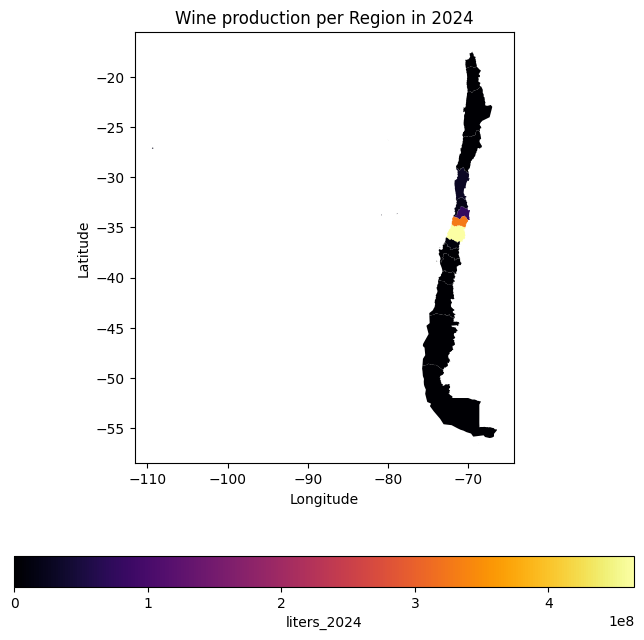

In [212]:
quick_plot_map(
    wine_production_by_region.to_pandas()
    , columns_color = [ 'liters_2024' ]
    , geo_col = 'geometry'
    , title = 'Wine production per Region in 2024'
)

Let's also visualize the earth features that we acquire from the raster data and the bigquery-public-data.

In [175]:
chile_features = bpd.read_gbq( f"""
  SELECT
    region_name
    , geometry
    , elevation_mean
    , water_mean
    , avg_npp
    , landcover_mean
    , fire_index
  FROM { BIGQUERY_DATASET }.wine_data_analysis
""")

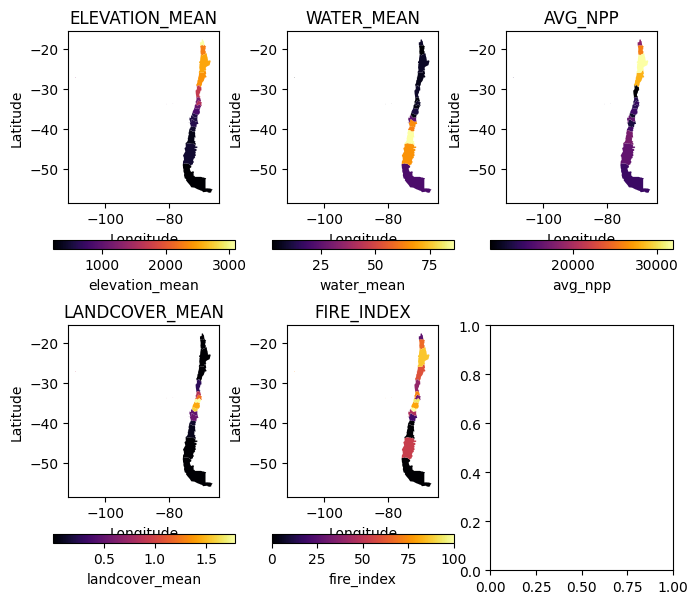

In [213]:
columns_to_plot = ["elevation_mean", "water_mean", "avg_npp", "landcover_mean", "fire_index"]
quick_plot_map(
    chile_features.to_pandas()
    , columns_color = columns_to_plot
    , geo_col = 'geometry'
    , subplots_x = 3
    , subplots_y = 2
    , size_x = 7
    , size_y = 8
)

## Step 4: Unlocking Hidden insights with a K-Means model using BigQuery ML

Now we will train a K-Means clustering model as an example method to segment land holdings into distinct groups based on the environmental characteristics already acquired from Earth Engine and BigQuery public data. As an unsupervised learning model, it automatically identifies natural groupings of regions without needing a pre-defined label. A company can use the resulting clusters to discover, for example, a "drought-prone" cluster that requires specific irrigation strategies, a "high-yield" cluster that warrants investment, or a "fire-vulnerable" cluster that needs targeted prevention programs. By moving beyond simple regional boundaries, this model provides a nuanced and data-driven perspective on land management, allowing for the creation of tailored, efficient, and highly effective agricultural strategies.



In [217]:
SQL = f"""
  CREATE OR REPLACE MODEL
    `{ BIGQUERY_DATASET }.kmeans_model`
  OPTIONS(
    model_type = 'KMEANS',
    num_clusters = 4,
    distance_type = 'EUCLIDEAN'
  ) AS
  SELECT
    elevation_mean
    , avg_npp
    , landcover_mean
    , water_mean
    , fire_index
    , liters_2024
    , ST_CENTROID(geometry) AS geometry_point
  FROM
    `{ BIGQUERY_DATASET }.wine_data_analysis`;
"""

In [ ]:
%%bigquery
$SQL

After aproximately one minute, we will find that the model was trained and we can see under **Execution details** some information about the iterations and duration.
![bqml_model_trained](../../../docs/images/assessing_risks_geospatial_bqml/bqml_model_trained.png)

Under Resutls, if you choose **Go To Model**, you can also find stats about the clusters identified.
![bqml_cluster_stats](../../../docs/images/assessing_risks_geospatial_bqml/bqml_cluster_stats.png)



## Step 5: Actionable cluster insights for strategic planning
This analysis identifies four distinct operational profiles for the wine producing regions, offering clear guidance for resource allocation and strategic planning.  The highest-producing clusters also carry the greatest risk.

* **Cluster 3** is your most profitable group, with the highest annual production of over 18 billion liters, but it also has a significant fire index and high elevation, which indicates a need for specialized terrain management and robust risk mitigation.
* **Cluster 1** is also a high-yield, high-risk group, producing over 267 million liters, making it a priority for fire prevention and resource protection.
* **Cluster 2** presents a low-risk, high-potential opportunity for future business development, due to its ample water and zero fire activity.
* Conversely, **Cluster 4** is an anomaly and an area for immediate investigation: despite having the highest average water availability, it has very low production. This indicates a potential inefficiency or different land use that could be optimized to increase output, representing a significant opportunity for growth.

Let's find below which regions belong to the clusters using the *ML.PREDICT* function to trigger the model inference.

In [241]:
SQL = f"""
  WITH cluster_analysis as (
    SELECT
      region, region_name, centroid_id CLUSTER_ID, rank() OVER(PARTITION BY centroid_id ORDER BY liters_2024 DESC) rank
    FROM
      ML.PREDICT(MODEL `{ BIGQUERY_DATASET }.kmeans_model`,
        (
          SELECT
            region
            , region_name
            , elevation_mean
            , avg_npp
            , landcover_mean
            , water_mean
            , fire_index
            , liters_2024
            , ST_CENTROID(geometry) AS geometry_point
          FROM
            `{ BIGQUERY_DATASET }.wine_data_analysis`
        )
      )
      ORDER BY
        CASE centroid_id
          WHEN 3 THEN 1
          WHEN 1 THEN 2
          WHEN 2 THEN 3
          ELSE 4
      END
    )
    SELECT region_name, CLUSTER_ID
    FROM cluster_analysis
    WHERE rank <= 3 AND CLUSTER_ID IN (1, 3);
"""

In [242]:
%%bigquery
$SQL

Query is running:   0%|          |

Downloading:   0%|          |

,region_name,CLUSTER_ID
0,Región Metropolitana de Santiago,3
1,Región de Coquimbo,3
2,Región de Valparaíso,3
3,Región del Maule,1
4,Región del Libertador General Bernardo O'Higgins,1
5,Región de Ñuble,1


**Conclusion**

This analysis demonstrates how to pinpoint areas with both high agricultural output and environmental risks, such as wildfires. This insight is crucial for implementing proactive, data-driven strategies that protect investments and mitigate potential losses.




## Cleanup

In [ ]:
!bq rm -r -f $GOOGLE_CLOUD_PROJECT:$BIGQUERY_DATASET
gsutil rm -r gs://$BUCKET_NAME